# Calibrating absorbed power using the shot noise level

In [1]:
from notebooks.library.display import toggle_input_code
toggle_input_code()

In [2]:
from kid_readout.analysis import archive
plt.rcParams['font.size'] = 11

/home/local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


updated file list


In [3]:
from scipy.constants import h
nu = 140e9
dark_channels = (0, 2, 4, 10)

In [4]:
df = archive.load_archive('/home/data/archive/2015-05-1819_mmw_140_GHz.npy')

In [20]:
atten = 23
turns = 4.0
single_channel = 9
one = df[(df.atten==atten) & (df.mmw_atten_total_turns/2==turns) & (df.timestream_modulation_duty_cycle==0)].copy()

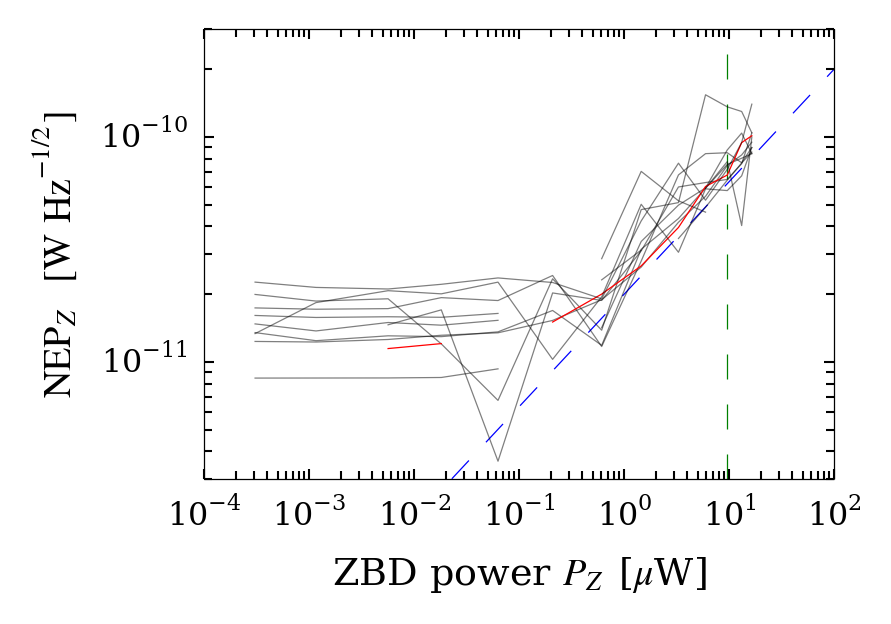

In [21]:
fig, ax = plt.subplots()

PP = np.logspace(-4, 2, 1e3)
ax.loglog(PP, 2e-11 * PP**(1/2), '--b')
ax.axvline(1e6 * one.zbd_power.iloc[0], color='green', linestyle='--')

for channel, group in df[df.atten==atten].groupby('channel'):
    if channel not in dark_channels and channel != single_channel:
        group = group.sort('zbd_power')
        ax.loglog(1e6 * group.zbd_power, group.zbd_power_NEP2_device**(1/2), '-', alpha=0.5, color='black')
    elif channel == single_channel:
        group = group.sort('zbd_power')
        ax.loglog(1e6 * group.zbd_power, group.zbd_power_NEP2_device**(1/2), '-', alpha=1, color='red')

ax.set_xlabel('ZBD power $P_Z$ [$\mu$W]')
ax.set_ylabel('$\mathrm{NEP}_Z \; [\mathrm{W} \, \mathrm{Hz}^{-1/2}]$')


ax.set_ylim(3e-12, 3e-10);

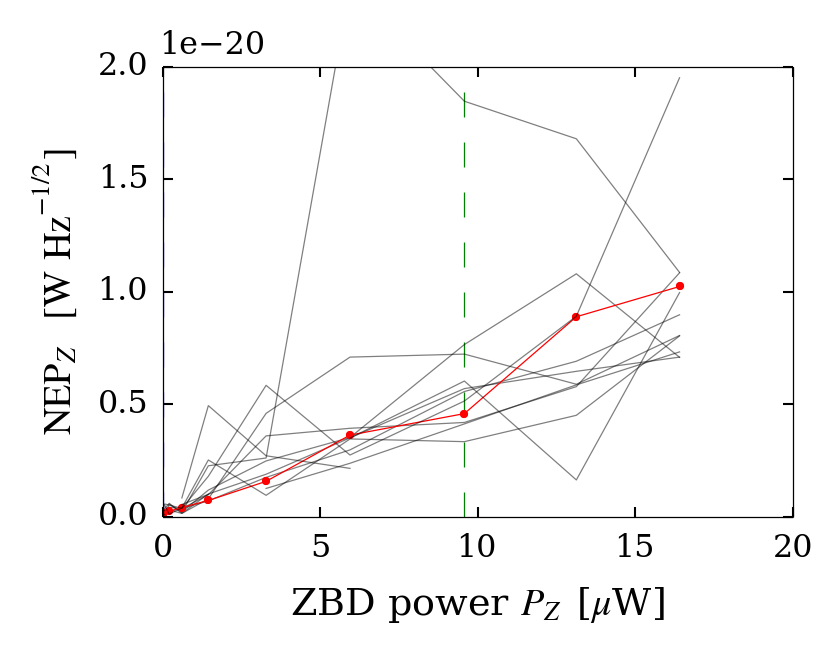

In [22]:
fig, ax = plt.subplots()

PP = np.linspace(0, 20, 1e3)
ax.plot(PP, 2e-11 * PP**(1/2), '--b')
ax.axvline(1e6 * one.zbd_power.iloc[0], color='green', linestyle='--')

for channel, group in df[df.atten==atten].groupby('channel'):
    if channel not in dark_channels and channel != single_channel:
        group = group.sort('zbd_power')
        ax.plot(1e6 * group.zbd_power, group.zbd_power_NEP2_device, '-', alpha=0.5, color='black')
    elif channel == single_channel:
        group = group.sort('zbd_power')
        ax.plot(1e6 * group.zbd_power, group.zbd_power_NEP2_device, '.-', alpha=1, color='red')

ax.set_xlabel('ZBD power $P_Z$ [$\mu$W]')
ax.set_ylabel('$\mathrm{NEP}_Z \; [\mathrm{W} \, \mathrm{Hz}^{-1/2}]$')

ax.set_ylim(0, 2e-20);

The quantities we measure are ZBD power $P_Z$, responsivity to ZBD power $\partial X / \partial P_Z$, and the single-sided fractional frequency power spectral density $S_{xx}$ of the time-ordered data.

(Aside: I'm using lowercase $x$ to denote the fractional frequency shift in the time-ordered data, and uppercase $X$ to denote the fractional frequency shift measured from frequency sweeps. The quantity that actually goes into the NEP calculation is the white noise level of $S_{xx}(f)$ in the detector bandwidth $f < f_c$. I can't think of any reason why $x$ and $X$ aren't interchangeable here, I'm just pointing out that we measure the responsivity at zero frequency.)

The NEP referred to the power at the ZBD is

\begin{align*}
\mathrm{NEP}_Z^2
  &=
  \frac{S_{xx}}{(\partial X / \partial P_Z)^2}.
\end{align*}

If the photon source is coherent so that there is negligible wave noise, then the NEP referred to the absorbed power $P_A$ is the sum of photon shot noise, recombination noise, and other noise contributions:

\begin{align*}
\mathrm{NEP}_A^2
  &=
  \mathrm{NEP}_C^2 + 2 h \nu P_A + 2 (2 \Delta) P_A / \eta_{pb},
\end{align*}

where $\mathrm{NEP}_C$ is independent of absorbed power, $\nu$ GHz is the photon frequency, and $\eta_{pb}$ is the fraction of photon energy that goes into the steady-state quasiparticle system. (For the above data, $\nu = 140$ GHz.) At these frequencies, each absorbed photon excites two quasiparticles close to the gap (or maybe slightly more than this on average due to the effects of the nonthermal distribution). We can write $\eta_{pb} \approx (2 \Delta) / (h \nu)$, so that the recombination noise is

\begin{align*}
\mathrm{NEP}_r^2
  &=
  2 (2 \Delta) P_A / \eta_{pb}
  \approx
  2 h \nu P_A,
\end{align*}

which is equal to the photon shot noise. I think this makes sense.

For a given detector, let $\gamma$ be the ratio of the power $P_A$ absorbed in the detector to the power $P_Z$ detected at the ZBD: $P_A = \gamma P_Z$. Assume that $\gamma$ is independent of power, which it should be because we operate the ZBD in its linear regime and all other components are passive. Then, $\partial X / \partial P_A = \gamma^{-1} \partial X / \partial P_Z$ so

\begin{align*}
\mathrm{NEP}_Z^2
  &=
  \frac{\mathrm{NEP}_A^2}{\gamma^2} \\
  &= \frac{\mathrm{NEP}_C^2}{\gamma^2}
  + \frac{2 (2 h \nu P_A)}{\gamma^2} \\
  &= \frac{\mathrm{NEP}_C^2}{\gamma^2}
  + \frac{2 (2 h \nu P_Z)}{\gamma}.
\end{align*}

Since all quantities in this equation are known or measured except for $\mathrm{NEP}_C$ and $\gamma$, we can fit a line to $\mathrm{NEP}_Z^2$ and extract them. Once we have $\gamma$, we can reference everything to absorbed power.

This measurement is conceptually the same as the measurements done with a blackbody source at a photon frequency such that the occupancy $n(\nu, T) \ll 1$. The differences are, first, that it relies on the coherence of the microwave source, and, second, that one obtains the less-useful efficiency $\gamma$ instead of the quantum efficiency $\eta$ of the horn-KID system.

We plan to extract $\eta$ by measuring the power incident on each horn with the cryostat open using the ZBD coupled through a horn similar to those in the detector package. To the extent that this power does not change when the cryostat is cooled and the horn-ZBD combination has high efficiency, this measurement will allow us to calculate the ratio of incident and absorbed power.